# Creating Real-Time Decoding Algorithms to Understand How Neural Activity Enables Complex Behaviours

The field of Neuroscience is poised to enter a new era of understanding. Advances in recording technologies have given rise to an exponential increase in the amount of data that can be recorded from individual animals which opens up the possibility of gaining a much deeper understanding of how the brain enables complex behavior. However, to make sense of these new larger data sets, new data analysis methods are urgently needed. In this project, I plan to meet this need by working with Prof Ethan Meyers to develop real-time “neural decoding algorithms” that are able to convert raw neural activity into information about the sensory and behavioral stimuli that an animal is processing. In collaboration with Prof David Moorman’s lab at UMass Amherst, we plan to apply these real-time neural decoding algorithms to simultaneous recordings of large populations of neural activity in rat sensory and frontal cortex in order to predict which stimuli an animal is paying attention to.

The data analysis method I plan to develop in this project is called “neural decoding” and involves using machine learning pattern classifiers' to predict what information an animal is processing based on patterns of neural activity. In this project, I try to get this method working in simulation based on data found at http://www.readout.info/

The first step is to set up a data structure to hold the data. Below is the data structure used for this project. 

In [2]:
class Data():
    '''
    Defined type of 3 arrays of length being the number of neurons and the length of each entry is the number of
    samples
    '''
    def __init__(self):
        self.sampled_data = []
        self.labels = []
        self.time_stamps = []
    
    def bin_data(self, bin_size, sample_rate):
        '''
        Calculates the average firing rates in 150 ms bins sampled every 50 ms, the following commands can be used.
        Returns a data object but in a binned form
        '''
        binned = Data()
        
        for x in range(len(self.sampled_data)):
            binned_array = []
            stamps = []
            labels = []
            y = 0
            while True:
                bin = sum(self.sampled_data[x][y:y+bin_size]) / bin_size
                binned_array.append(bin)
                try:
                    labels.append(self.labels[x][y])
                except:
                    print(x)
                    print(y)
                    print(len(self.labels))
                    print(len(self.labels[x]), len(self.sampled_data[x]))
                    exit()
                stamps.append(y)
                if y + sample_rate >= len(self.sampled_data[x]):
                    break
                else:
                    y = y+sample_rate
            
            binned.sampled_data.append(binned_array)
            binned.time_stamps.append(stamps)
            binned.labels.append(labels)

        return binned


The next step is to extract the data from the folder downloaded at the link provided earlier. Below is the function that extract the data from the .mat files.

In [3]:
import sys
!{sys.executable} -m pip install rdata

In [4]:
import scipy.io as sio
import os
import numpy as np
import pandas as pd
import rdata

def get_mat_data():
    '''
    Function that returns the data of all the matlab data in the Zhang_Desimone_7objects_raster_data folder in the form
    of a list where each index corresponds to the data of one file
    Each index has the following information:
    raster_data is times from -500 to 500 and the data corresponding to these times
    raster_labels labels contains the position and ID (type of image shown)
    raster site info is the site info session ID, recording channel and the unit
    '''
    temp = os.path.join(os.getcwd(), "Zhang_Desimone_7objects_raster_data")
    mat_contents = []
    i = 1
    for name in os.listdir(temp):
        mat_contents.append(sio.loadmat("Zhang_Desimone_7objects_raster_data/"+name))

    parsed = rdata.parser.parse_file("ZD_150bins_50sampled.Rda")
    converted = rdata.conversion.convert(parsed)
    converted = converted['binned_data']
    return mat_contents, converted

Now to get the data from the files

In [5]:
NeuralData, BinnedData = get_mat_data()

/srv/conda/envs/notebook/lib/python3.6/site-packages/rdata/conversion/_conversion.py:590: UserWarning: Missing constructor for R class "binned_data". The constructor for class "data.frame" will be used instead.
  stacklevel=1)


The data we now have is now in raster format. Next, we need to convert this to a format to mimic that of data coming in from live probes from a rat, post spike sorting, below is the function to convert the files.

In [6]:
import numpy as np
import pandas as pd
import random
import sys

def random_sequence(objects, size):
    '''
    Function that returns a random sequence of valid objects shown to the mice where objects is the valid objects
    that can be shown and size is the number of trials we want to try
    '''
    order_num = np.random.randint(0,(len(objects)),size)
    order_objects = []
    for x in range (size):
        order_objects.append(objects[order_num[x]])

    return order_objects

def unique(list1):
    '''
    Function returns unique elements in a list
    '''
    # intilize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list


def transform_raster(temp):
    '''
    Function takes in parameter, temp, which contains many dictories dictionaries, each extracted 
    from one .mat files containing information from one neuron.  The function converts this data into a np matrix
    of neurons x number of samples taken (frequency x time)
    It also respons the corresponding labels in the format 132 x 420 where each entry is a dictionary of the 
    location and type of stimulus, as well as the combined. 
    '''
    data = []
    labels = []
    objects = []
    times = []
    for x in range(len(temp)):
        data.append(temp[x]['raster_data'])
        labels.append(temp[x]['raster_labels'])
        # objects.append(labels[x][0][0][0][0][0][0])
    #data is neurons x time x frequency, we want to now convert this to neurons x (time x frequency)
    #labels is neurons x 1 x 1 x 3(location, type and combination) x 1 x 420 x 1. we want to transform this to neurons x (time x frequency) 
    #Here each element will be a dictionary. 
    num_trials = len(data[0])-1  # the rows in one file representing the number of trials. -1 for the 419 trial tests
    num_neurons = len(data)
    labels = np.array(labels)
    for x in range (num_neurons):
        for y in range (num_trials-1):
            objects.append(labels[x][0][0][2][0][y][0])

    objects = unique(objects) #objects is now all the unique combination of location and type of stimulus shown
    #print(objects)
    order = random_sequence(objects, num_trials)
    sample = [] #sample is going to store our neurons x (time x frequency)
    new_labels = []

    for x in range (num_neurons): #number of neurons
        time = 0
        time_array = []
        temp = np.array([])
        temp_label = []
        for y in range (len(order)): #going through the order of our pseudo population
            valid_indexes = []
            for z in range(num_trials):
                if labels[x][0][0][2][0][z][0] == order[y]:
                    valid_indexes.append(z)
            index = random.choice(valid_indexes)

            temp1 = np.array(data[x][index])
            temp_label1 = {}
            temp_label1['location'] = labels[x][0][0][1][0][index][0]
            temp_label1['type'] = labels[x][0][0][0][0][index][0]
            temp_label1['combined'] = labels[x][0][0][2][0][index][0]
            temp_label.append(temp_label1)
            temp = np.concatenate((temp,temp1))
            time_array.append(time)
            time = time + 0.001
            time = round(time,3)
        sample.append(temp) 
        new_labels.append(temp_label)
        times.append(time_array)

    temp = []
    no_stimuli = {}
    no_stimuli['location'] = "None"
    no_stimuli['type'] = "None"
    no_stimuli['combined'] = "None"
    for x in range (len(new_labels)):
        temp1 = []
        for y in range (len(new_labels[x])):
            for i in range (500):
                temp1.append(no_stimuli)
            for i in range (500):
                temp1.append(new_labels[x][y])
        temp.append(temp1)

    new_labels = temp # labels is now the same dimension of sample
    # sample = np.array(sample)
    # times = np.array(times)
    return sample, new_labels, times

In [7]:
sampled_data, labels, timestaps = transform_raster(NeuralData) #sampled data now contains neural samples of 132 neurons, sampled at 1000Hz for 420 seconds. (132 x 420000)

Now we need to place this in a data structure to something that would mimic data coming in from an Open Ephys platform: labels, and 132 channels of neural data post spike sorting. 

In [8]:
data = []
data.append(labels[0])
for x in range(len(sampled_data)):
    data.append(sampled_data[x])

Now we have the data in the format that can mimic data coming in from open ephys, and we can start our training and decoding. First, we should set up our plots. (Numbers may need adjusting due to screensize)

Text(0, 0.5, 'Correlation')

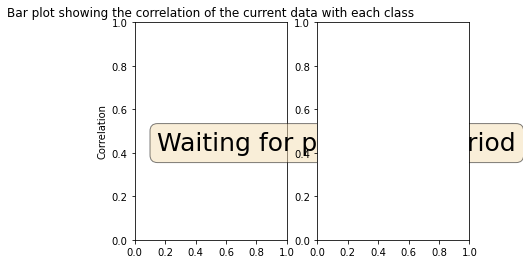

In [10]:
import matplotlib.pyplot as plt
plt.ion()
fig, axis = plt.subplots(1,2)
ax1 = axis[0]
ax2 = axis[1]
x1=[]
y1= []
for x in range(132):
    y1.append([])
lines = None
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax1.text(0.15, 0.5, "Waiting for predicting period" , transform=ax1.transAxes, fontsize=25, verticalalignment='top', bbox=props)
ax1.title.set_text('Bar plot showing the correlation of the current data with each class')
ax1.set_ylabel('Correlation')

Next, we set up a loot to mimic our training phase, going through 80% of our neural data.But first, the helper functions.

In [12]:
from io import TextIOBase
from numpy.core.numeric import correlate
import numpy as np
import pandas as pd
import datetime
import time
import pickle
from sklearn.metrics import matthews_corrcoef
import sys
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import matplotlib.animation as animation
import time
from matplotlib.widgets import Slider
import matplotlib.pyplot as plt

In [13]:
def grab_size(start, data, size):
    '''
    Function that grabs size recordings of data from matrix that is supposed to mimic that of open Ephys
    data is the neurons array, and in this case its the raster data, start is the start column to read from 
    '''
    result = [] #This is going to be the neurons + 1 by size array
    for x in range(len(data)): # for each channel
        temp = []
        for y in range(size):
            temp.append(data[x][y+start])
        
        result.append(temp)
    return result

def add_to_trainset(train, added):
    '''
    train is our train set and adds added to the training set which is the labels and neurons array
    '''
    if train.sampled_data == []: #here our train set is un initialized
        for x in range (len(added)-1): # set up the 132 rows
            train.sampled_data.append(added[x+1])
        train.labels = concatenate(train.labels, (added[0]))
    else:
        for x in range (len(added )-1): # go through the 132 rows 
            train.sampled_data[x] = concatenate(train.sampled_data[x], added[x+1])
            
        train.labels = concatenate(train.labels, (added[0]))
    return train

def concatenate (arr1, arr2):
    '''
    concatenates arr2 to arr1
    '''
    for x in range(len(arr2)):
        arr1.append(arr2[x])
    
    return arr1

def find_index(dict, label):
    '''
    function that finds the index of a particular label in a dictionary
    '''
    index = 0
    for key in dict:
        if key == label:
            return index
        else:
            index = index+1

    return -1

def update_plot1(fig,ax,cors,a,r,mse,cos):
    for x in range (len(a)):
        ax.clear()
        correlations = cors[x]
        label = a[x]
        r_prediction = r[x]
        mse_prediction = mse[x]
        cos_prediction = cos[x]
        if (label != 'pass'):
            #print("label: " + label + "\tr^2: " +r_prediction + "\tmse: " +mse_prediction + "\tcos: " +cos_prediction)
            keys = correlations.keys()
            values = correlations.values()
            #if count == 0:
            rects = ax.bar(keys, values)
            ax.set_ylim([0,1])
            ax.title.set_text('Bar plot showing the correlation of the current data with each class')
            ax.set_ylabel('Correlation')
                    
            for rect,h in zip(rects,values):
                rect.set_height(h)
                
            if label == r_prediction:
                rects[find_index(correlations, label)].set_color('g')
                c1 = 'g'
                c2 = 'g'
            else:
                rects[find_index(correlations, r_prediction)].set_color('r')
                rects[find_index(correlations, label)].set_color('m')
                c1 = 'r'
                c2 = 'm'
                    
            fig.canvas.draw()
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
            ax.text(0.05, 0.95, "Actual: "+label, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
            ax.text(-0.7,0.93, u'\u25CF', color = c2)

            ax.text(0.05, 0.85, "Predicted: "+r_prediction, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
            ax.text(-0.7,0.83, u'\u25CF', color = c1)
            plt.pause(0.0001)

        
        else:
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
            ax.text(0.05, 0.95, "Low correlation", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


def update_plot2(fig ,num_channels, ax, x, y, lines, count, set):
    sampled_data = set.sampled_data
    label = set.labels[0][0]['type']
    #print(len(x),len(y[0]))
    x.append(count/5)
    for i in range(num_channels):
        y[i].append(sampled_data[i][0])
        if len(x)>100:
            y[i] = y[i][1:]
    if (len(x)>100):
        x = x[1:]

    if lines == None:
        ax.title.set_text('Graph showing the average average spike firing rate')
        lines = {}
        ax.set_ylim([-1,150])
        # ax.set_yticks(range(-1, 151))
        # ax.yaxis.set_tick_params(labelsize=5)
        for i in range (num_channels):
            lines[i], = ax.plot([0], [i])

        ax.set_xlabel("Time in the experiment in seconds")
        ax.set_ylabel("Channel/Neuron number and Average Firing Rate \n spike firing rate = (y - neuron number)/(8 * 0.2) Hz")

    for i in range(num_channels):
        lines[i].set_xdata(x)
        temp =  [(a + i*0.125)*8 +1 for a in y[i]] 
        lines[i].set_ydata(temp)

    if len(x) == 100:
        ax.set_xlim([min(x),max(x)])
    else:
        ax.set_xlim([0,20])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    for txt in ax.texts:
        txt.set_visible(False)
    ax.text(0.6, 0.95, "Image being shown: "+label, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    fig.canvas.draw()
    fig.canvas.flush_events()

    return lines,x,y
#     # updating data values

def train(train_set):
    '''
    Trains our model and returns our models for our classes. Here train_set represnts our training set
    '''
    names = []
    for x in range(len(train_set.labels[0])):
        names.append(train_set.labels[0][x]['type'])

    class_names = unique(names) #the 8 class names

    classes = {} # this is a dictionary of the 8 classes which have arrays of the length of the number of neurons
    zeroed = [0] * (len(train_set.sampled_data)+1) # the extra 1 indicates the number of occurences 
    for name in class_names :
        classes[name] = np.array(zeroed)
    #training:
    for x in range(len(train_set.sampled_data[0])):
        label = train_set.labels[0][x]['type']
        #print(label)
        neurons = []
        for y in range(len(train_set.sampled_data)):
            neurons.append(train_set.sampled_data[y][x])
        neurons.append(1)
        neurons = np.array(neurons)
        #neuron is now of length 133, containing a column of raster data, and 1 for once occurence
        #Now adding it to the relevant class
        classes[label] = classes[label]+neurons 


    for key in classes :
        array = (classes[key]/classes[key][len(classes[key])-1])
        classes[key] = array[0:len(classes[key])-1] #Get the average over all the bins and remove the counter 

    return classes

def predict(test_set, classes):
    '''
    makes predictions for the passed in set and returns arrays of the actual labels, and the corresponding predictions
    '''
    correlations = []
    actual = []
    rpredicted = []
    msepredicted = []
    cospredicted = []

    for x in range(len(test_set.sampled_data[0])):
        label = test_set.labels[0][x]['type']
        neurons = []
        for y in range(len(test_set.sampled_data)):
            neurons.append(test_set.sampled_data[y][x])
        neurons = np.array(neurons)

        rs = {}
        mses = {}
        coses ={}

        for key in classes :
            object = key
            array = classes[key]
            mse = ((array - neurons)**2).mean()
            cos =cosine_similarity([array], [neurons])[0][0]
            try :
                r = np.corrcoef(array, neurons)[0,1]
            except:
                r = mse

            rs[key] = r
            mses[key] = mse
            coses[key] = cos
            
        r_prediction = max(rs, key=rs.get)
        mse_prediction = min(mses, key=mses.get)
        cos_prediction = max(coses, key=coses.get)
        
        p = False
        if (round(rs[r_prediction],2) <0.4):
            p = True
            actual.append('pass')
            rpredicted.append('pass')
            msepredicted.append('pass')
            cospredicted.append('pass')
        else:
            actual.append(label)
            msepredicted.append(mse_prediction)
            rpredicted.append(r_prediction)
            cospredicted.append(cos_prediction)

        correlations.append(rs)
        #print("label: " + label + "\tr^2 " +str(round(rs[r_prediction],2))+": " +r_prediction)

    return actual, rpredicted, msepredicted, cospredicted, correlations

Now that we have the necessary functions set up, we can start the driving program

In [ ]:
index = 0
train_set = Data()
train_set.sampled_data = [] 
train_set.labels = []
loop_counter = 0
num_channels = len(data)

while index < len(data[0]) * 0.8 :
    temp_set = Data()
    temp = grab_size(index, data, 200) #In the open ephys, this temp would be simply the data receieved from the plugin
    train_set = add_to_trainset(train_set,temp)#We now want to add temp to our training set 
    temp_set = add_to_trainset(temp_set,temp)

    #plot
    temp = []
    for x in range (len(temp_set.sampled_data)):
        temp.append(temp_set.labels)
    temp_set.labels = temp
    temp_set = temp_set.bin_data(200,200)
    lines, x1 , y1 = update_plot2(fig ,num_channels-1, ax2, x1, y1,  lines, loop_counter, temp_set)
    #

    index = index + 200

    if (index > len(data[0])):
        index = 0 

    t2 = datetime.datetime.now()
    loop_counter = loop_counter +1

We now have finished collected data from the training set, now realigning our training set and bin the data to form our classes for predictions.

In [ ]:
temp = []

for x in range (len(train_set.sampled_data)):
    temp.append(train_set.labels)
train_set.labels = temp


train_set = train_set.bin_data(200,200)
classes = train(train_set)

We have finished training the data, and now we can start predicting on the last 20% of data

In [ ]:
actual = []
rpredicted = []
msepredicted = []
cospredicted = []

count = 0

while index < len(data[0]) :
    test_set = Data()
    temp = grab_size(index, data, 200) 
    test_set = add_to_trainset(test_set,temp)

    temp = []
    for x in range (len(test_set.sampled_data)):
        temp.append(test_set.labels)
    test_set.labels = temp

    test_set = test_set.bin_data(200,200)
    a, r, mse, cos, cors = predict(test_set, classes)
    #plots
    update_plot1(fig,ax1,cors,a,r,mse,cos)
    
    lines, x1 , y1 = update_plot2(fig ,num_channels-1, ax2, x1, y1, lines, loop_counter, test_set)
    #end plots
    actual = concatenate(actual, a)
    rpredicted = concatenate(rpredicted, r)
    msepredicted = concatenate(msepredicted, mse)
    cospredicted = concatenate(cospredicted, cos)

    index = index + 200

    #now we plot
    #

    time.sleep(0.1)
    t2 = datetime.datetime.now()
    count = count+1
    loop_counter = loop_counter + 1
    

Lastly, a summary of our experiment. 

In [ ]:
len1 = len(actual)

actual = [value for value in actual if value != 'pass']
rpredicted = [value for value in rpredicted if value != 'pass']
msepredicted = [value for value in msepredicted if value != 'pass']
cospredicted = [value for value in cospredicted if value != 'pass']
len2  = len(actual)

print()

print("Accuracy: ", round(accuracy_score(actual, rpredicted)*100,2), "%", "\tmatthews corr coef: ", round(matthews_corrcoef(actual, rpredicted),2),"\tF1: ", round(f1_score(actual, rpredicted, average = 'weighted'),2), sep = "")
print()

This concludes the simulation of live time decoding. This method showed to have an constant accuaracy above 75%. The next steps would to either insert this method into the pipeline of live time analysis of neural data, or try to improve on this algorithm